In [1]:
# Gensim
import gensim
from gensim.models import Word2Vec


# to make nbs importable
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
#from nbs_import import NotebookLoader

import pandas as pd
import numpy as np

# custom
from analize_text import get_sentenceID
from paths import *


# nltk
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk import pos_tag, pos_tag_sents

from multiprocessing import cpu_count

# scikit learn
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

# keras
from keras.utils import np_utils

from feature_transformer import *

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading the dataframes

In [2]:
# read dataframes of sentences and entities

# TRAIN SET
sentences_df_train = pd.read_csv(SENTENCE_PATH_train)
entities_df_train = pd.read_csv(ENTITY_PATH_train)

#TEST SET
sentences_df_test1 = pd.read_csv(SENTENCE_PATH_test1)
entities_df_test1 = pd.read_csv(ENTITY_PATH_test1)

#TEST2 SET
sentences_df_test2 = pd.read_csv(SENTENCE_PATH_test2)
entities_df_test2 = pd.read_csv(ENTITY_PATH_test2)

print(len(sentences_df_train), len(sentences_df_test1), len(sentences_df_test2))

6832 664 1299


### Loading the dataset (embeddings_POS)

In [3]:
data_path = os.path.join(ROOT_DIR, 'XY', 'LEMMA_20')
X_test2 = np.load(os.path.join(data_path, 'X_test2.npy'))
X_test1 = np.load(os.path.join(data_path, 'X_test1.npy'))
X_train = np.load(os.path.join(data_path, 'X_train.npy'))

Y_test2 = np.load(os.path.join(data_path, 'Y_test2.npy'))
Y_test1 = np.load(os.path.join(data_path, 'Y_test1.npy'))
Y_train = np.load(os.path.join(data_path, 'Y_train.npy'))

print(X_train.shape, Y_train.shape)
print(X_test1.shape, Y_test1.shape)

(148031, 20) (148031,)
(14896, 20) (14896,)


### Loading the embeddings

In [17]:
w2vmodel = Word2Vec.load('../word_vectors_stem_20')
word_vectors = w2vmodel.wv

### Encode labels
- Convert labels from B-I-O to $0, 1, 2$ for SVM
- Convert labels from B-I-O to $[1 0 0, 0 1 0, 0 0 1]$ for ANN

In [18]:
# encode class values as integers = B-I-O -> 0-1-2
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y_train)
Y_train = encoded_Y
# convert integers to one-hot encoding
Y_train_one_hot = np_utils.to_categorical(encoded_Y) # SVM does not need one-hot encoding

### Data preprocessing
experiment with:
- original data
- MinMaxScaler
- Standardizer

In [ ]:
#min_max_scaler = MinMaxScaler()
#X_train = min_max_scaler.fit_transform(X_train)

#standard_scaler = StandardScaler()
#X_train = standard_scaler.fit_transform(X_train)

### Split train / validation set

In [19]:
train_perc = 1
train_size = int(len(X_train) * train_perc)

# split train validatioin (NN)
X_tr, X_vl = X_train[:train_size,:], X_train[train_size:,:]
Y_tr_nn, Y_vl_nn = Y_train_one_hot[:train_size], Y_train_one_hot[train_size:]

print ("X train/validation shapes:", X_tr.shape, X_vl.shape)
print ("Y train/validation shapes: ", Y_tr_nn.shape, Y_vl_nn.shape)

X train/validation shapes: (148031, 20) (0, 20)
Y train/validation shapes:  (148031, 3) (0, 3)


### Using ANN

In [20]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn import preprocessing
from keras.optimizers import *
from keras.initializers import *

import matplotlib.pyplot as plt

In [28]:
num_inputs = X_train.shape[1] # size of a vector
num_outputs = 3 # b-i-o tags

model = Sequential()

model.add(Dense(units=512, input_shape=(num_inputs,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(units=128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(units=num_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               10752     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 142,851
Trainable params: 142,851
Non-trainable params: 0
_________________________________________________________________


### Training callbacks
- F1-score
- Precision
- Recall

In [ ]:
import numpy as np
from keras.callbacks import Callback

class Metrics(Callback):

    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val
    
    def on_train_begin(self, logs={}):
        self.val_f1s_micro = []
        self.val_recalls_micro = []
        self.val_precisions_micro = []
        self.val_f1s_macro = []
        self.val_recalls_macro = []
        self.val_precisions_macro = []
        self.val_f1s_weighted = []
        self.val_recalls_weighted = []
        self.val_precisions_weighted = []
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax((np.asarray(self.model.predict(self.x_val))), axis=1)
        val_targ = np.argmax(self.y_val, axis=1)
        # micro
        f1_micro = f1_score(val_targ, val_predict, average='micro')
        recall_micro = recall_score(val_targ, val_predict, average='micro')
        precision_micro = precision_score(val_targ, val_predict, average='micro')
        # macro
        f1_macro = f1_score(val_targ, val_predict, average='macro')
        recall_macro = recall_score(val_targ, val_predict, average='macro')
        precision_macro = precision_score(val_targ, val_predict, average='macro')
        # weighted
        f1_weighted = f1_score(val_targ, val_predict, average='weighted')
        recall_weighted = recall_score(val_targ, val_predict, average='weighted')
        precision_weighted = precision_score(val_targ, val_predict, average='weighted')
        
        # append metrics to access them later
        # micro
        self.val_f1s_micro.append(f1_micro)
        self.val_recalls_micro.append(recall_micro)
        self.val_precisions_micro.append(precision_micro)
        # macro
        self.val_f1s_macro.append(f1_macro)
        self.val_recalls_macro.append(recall_macro)
        self.val_precisions_macro.append(precision_macro)
        # weighted
        self.val_f1s_weighted.append(f1_weighted)
        self.val_recalls_weighted.append(recall_weighted)
        self.val_precisions_weighted.append(precision_weighted)
        
        print (" — val_f1_micro: %.4f — val_precision_micro: %.4f — val_recall_micro: %.4f" % (f1_micro, precision_micro, recall_micro))
        print (" — val_f1_macro: %.4f — val_precision_macro: %.4f — val_recall_macro: %.4f" % (f1_macro, precision_macro, recall_macro))
        print (" — val_f1_weighted: %.4f — val_precision_weighted: %.4f — val_recall_weighted: %.4f" % (f1_micro, precision_micro, recall_micro))
        return

    
metrics_callback = Metrics(x_val=X_vl, y_val=Y_vl_nn)

In [29]:
epochs = 30
batch_size = 16

history = model.fit(X_tr, Y_tr_nn, 
                    epochs=epochs, 
                    shuffle=True, verbose=1, 
                    batch_size=batch_size,
                    #validation_data=(X_vl, Y_vl_nn),
                    #callbacks=[metrics_callback]
                   )

Epoch 1/30
148031/148031 [==============================] - 34s 226us/step - loss: 0.2457 - acc: 0.9021
Epoch 2/30
148031/148031 [==============================] - 34s 231us/step - loss: 0.2254 - acc: 0.9099
Epoch 3/30
148031/148031 [==============================] - 33s 222us/step - loss: 0.2196 - acc: 0.9111
Epoch 4/30
148031/148031 [==============================] - 33s 220us/step - loss: 0.2156 - acc: 0.9132
Epoch 5/30
148031/148031 [==============================] - 34s 232us/step - loss: 0.2128 - acc: 0.9151
Epoch 6/30
148031/148031 [==============================] - 34s 230us/step - loss: 0.2106 - acc: 0.9157
Epoch 7/30
148031/148031 [==============================] - 35s 240us/step - loss: 0.2096 - acc: 0.9167
Epoch 8/30
148031/148031 [==============================] - 33s 223us/step - loss: 0.2080 - acc: 0.9174
Epoch 9/30
148031/148031 [==============================] - 34s 231us/step - loss: 0.2064 - acc: 0.9178
Epoch 10/30
148031/148031 [==============================] - 35s

In [ ]:
# max micro and macro f1 score obtained
f1_micro = metrics_callback.val_f1s_micro
f1_macro = metrics_callback.val_f1s_macro

print("max f1 micro:", np.round(np.max(f1_micro), 4), "epoch:", np.argmax(f1_micro))
print("max f1 macro:", np.round(np.max(f1_macro), 4), "epoch:", np.argmax(f1_macro))

### Plot of Loss and Accuracy

KeyError: 'val_loss'

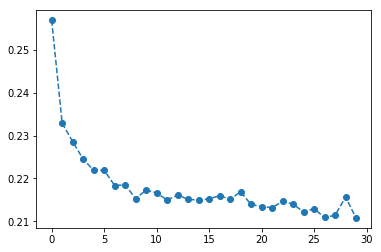

In [11]:
plt.plot(history.history['loss'], label='training loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='validation loss', linestyle='-', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Categorical cross-entropy')
plt.legend(loc='best')
plt.savefig('../draft_presentation/images/loss.png')
plt.show()

plt.plot(history.history['acc'], label='training accuracy', linestyle='--', marker='o')
plt.plot(history.history['val_acc'], label='validation accuracy', linestyle='-', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig('../draft_presentation/images/accuracy.png')
plt.show()

### Plot of F1-score, Precision and Recall (micro)

In [ ]:
plt.plot(metrics_callback.val_f1s_micro, label='f1-score', marker='o', alpha=0.7)
plt.plot(metrics_callback.val_precisions_micro, label='precision', marker='D', alpha=0.7)
plt.plot(metrics_callback.val_recalls_micro, label='recall', marker='*', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Micro-averaged performance')
plt.legend(loc='best')
plt.savefig('../draft_presentation/images/micro.png')
plt.show()

### Plot of F1-score, Precision and Recall (macro)

In [ ]:
plt.plot(metrics_callback.val_f1s_macro, label='f1-score', marker='o', alpha=0.7)
plt.plot(metrics_callback.val_precisions_macro, label='precision', marker='D', alpha=0.7)
plt.plot(metrics_callback.val_recalls_macro, label='recall', marker='*', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Macro-averaged performance')
plt.legend(loc='best')
plt.savefig('../draft_presentation/images/macro.png')
plt.show()

### Plot of F1-score, Precision and Recall (weighted)

In [ ]:
plt.plot(metrics_callback.val_f1s_weighted, label='f1-score', marker='o', alpha=0.7)
plt.plot(metrics_callback.val_precisions_weighted, label='precision', marker='D', alpha=0.7)
plt.plot(metrics_callback.val_recalls_weighted, label='recall', marker='*', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Weighted-averaged performance')
plt.legend(loc='best')
plt.savefig('../draft_presentation/images/weighted.png')
plt.show()

# Test
IdSentence|startOffset-endOffset|text|null

In [12]:
def token_spans(txt):
    token_offset = []
    tokens = nltk.word_tokenize(txt)
    offset = 0
    for token in tokens:
        offset = txt.find(token, offset)
        token_offset.append((token, offset, offset+len(token)-1))
        offset += len(token)
    return tokens, token_offset

In [13]:
def find_end_entity_index(labels_list, current_word_index):
    end_entity_index = current_word_index
    for i in range(current_word_index + 1, len(labels_list)):
        if labels_list[i] == 1: # if label == I
            end_entity_index += 1
            continue
        else:
            break
    return end_entity_index

In [14]:
stemmer = EnglishStemmer()

In [15]:
def tokenize_with_POS(sentences, pos=True, stem=True):
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    tokenized_pos = pos_tag(tokenized_sentences, tagset=None)
    
    if pos is False and stem is False:
        print('original')
        return tokenized_sentences
    if stem and pos:
        print('stem + pos')
        tokenized_pos = [ [stemmer.stem(w) + '_' + pos for w, pos in s ] for s in tokenized_pos]
    if stem and pos is False:
        print('stem')
        tokenized_pos = [ [stemmer.stem(w) for w in s ] for s in tokenized_sentences]
    else:
        print('pos')
        tokenized_pos = [ [w + '_' + pos for w, pos in s ] for s in tokenized_pos]
    return tokenized_pos 

### output file

In [30]:
output_string = ''
vector_size = 20


for index, row in sentences_df_test1.iterrows():
    sentenceId = row['sentenceID']
    sentenceText = row['sentenceText']
    # 1. tokenize sentence
    tok_sentence, token_offset = token_spans(sentenceText)
    # 2. add part of speech
    #tok_sentence_pos = [ word + '_' + pos for word, pos in pos_tag(tok_sentence, tagset=None)]
    tok_sentence_pos = [ stemmer.stem(word) for word, pos in pos_tag(tok_sentence, tagset=None)]
    # 3. get word vectors, predict and write output line
    vectors_to_predict = np.array([]).reshape(0, vector_size)
    for word in tok_sentence_pos:
        vector = word_vectors[word]
        vectors_to_predict = np.vstack((vectors_to_predict, vector))
    # 4. predict
    predictions = model.predict(vectors_to_predict)
    predicted_labels = np.argmax(predictions, axis=1)
    # 5. generate output
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == 0:
            end_entity_index = find_end_entity_index(predicted_labels, i)
            start = token_offset[i][1]
            end = token_offset[end_entity_index][2]
            output_string += sentenceId + '|' + str(start) + '-' + str(end) + '|' + sentenceText[start:end+1] + '|null\n'

In [31]:
output_file_task_1 = '../results/task9.1_GROUP_1.txt'
with open(output_file_task_1, "w") as out_file:
    out_file.write(output_string)